# Different training procedures

 ## What's it?

Using `train_steps`, we  can configure different training procedures. It allows optimizing weights in selected scope using selected optimizer, loss and learning rate decay.

`scope` – a subset of weights to optimize during training. It can be either string or sequence of strings.
The value `''` is reserved for optimizing all trainable variables. Putting `-` sign before name stands for complement: optimize everything but the passed scope. The scope can be chosen from masks of the path to model weights tensors.

A scope can be set up as a list of scopes:
```python
'scope': ['block/group-0/some_layer', 'block/some_group']
```

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt

sys.path.append('../../..')
from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.models.tf import EncoderDecoder

Specify which GPU(s) to be used. More about it in [CUDA documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars).

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


## Create a dataset, define a pipeline config, define a default model config


In [3]:
BATCH_SIZE = 64

dataset = MNIST()

config = dict(model=EncoderDecoder)

model_config = {'inputs/images/shape': B.image_shape,
                'inputs/masks/shape': B.image_shape,
                'initial_block/inputs': 'images',
                'body/encoder/num_stages': 3,
                'body/encoder/blocks': {'layout': 'cna cna',
                                        'kernel_size': 3,
                                        'filters': [16, 32, 128]},
                'body/decoder/blocks': {'layout': 'cna cna',
                                        'kernel_size': 3,
                                        'filters': [64, 32, 16]},
                'head': dict(layout='cna', kernel_size=3, filters=16),
                'loss': 'mse'}

In the Encoder-Decoder architecture, a network is partitioned into two parts: the encoder, and the decoder. The encoder’s role is encoding the inputs into a state, which is called embedding. Then the state is passed into the decoder to generate outputs.
More about implementation of [EncoderDecoder in batchflow](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.encoder_decoder.html).

# Add different training procedures 

`'train_steps'` is a mapping from names (more on that later) to parameters for configuring training procedure. Choose the optimizer, the scope of weights of your neural network, and the learning rate decay config 
([avalible losses and decays](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.base.html)). For example:


```python
'train_steps': {'name_of_train_step': {'optimizer': 'Adam', 
                                       'scope': 'block/group/layer', 
                                       'decay': lr_decay_config, 
                                       'loss': 'mse'}}
```

In [4]:
model_config.update(
    {'train_steps':
     {
        'encoder': {'optimizer': 'Adam', 'scope': ['body/encoder', 'initial_block'], 'loss': 'mse'},
        'decoder': {'optimizer': 'Adam', 'scope': ['body/decoder', 'head'], 'loss': 'mse'}
     }
    })

Optimizer and decay together may be reused by another **train step**. Apply the key `'use'`  in a **train_step** with the name of the **train_step** whose optimizer and decay you want to use.

For example:
```python
'all_mse_decay': {'optimizer': 'Adam', 'loss': 'mse', 'decay': lr_decay_config}
'head': {'use': 'all_mse_decay', 'scope': 'head', 'loss': 'ce'}
 ```

A scope contains all trainable variables if it isn't set (as in the case `'all_mse_decay'` train step).

# Example of usage

## Train the model

Parameter `train_mode` used in `train_model` pipeline action to select *train step*. 

For example use:
```python 
train_mode='name_of_train_step'
```
to select `name_of_train_step`.

To fetch loss according to selected *train_step* use:
```python 
fetches='loss_name_of_train_step'
``` 

Now use `train_mode='encoder'`  to select train step `'encoder'`. And `fetches='loss_encoder'` to fetch corresponding loss.

Let's, define the function that displays mean values of the encoder and decoder tensor at each pipeline iteration to look at a change in values when changing **train_step**. And also select the tensors we want to monitor.

In [5]:
tensors_to_fetch = ['body/encoder/encoder-0/block/layer-3/conv2d_1/Conv2D/ReadVariableOp',
                    'body/decoder/decoder-2/block/layer-3/conv2d_12/Conv2D/ReadVariableOp']

def plot_tensor_mean(encoder_tensor, decoder_tensor):
    plt.plot([tensor.mean() for tensor in encoder_tensor], label='Mean of encoder tensor')
    plt.plot([tensor.mean() for tensor in decoder_tensor], label='Mean of decoder tensor')
    plt.legend()
    plt.show()

In [6]:
train_encoder = (Pipeline(config=config)
                 .init_variable('encoder_tensor', [])
                 .init_variable('decoder_tensor', [])
                 .init_model('dynamic', C('model'),'conv_nn',
                             config=model_config)
                 .to_array()
                 .train_model('conv_nn', fetches=tensors_to_fetch, 
                              train_mode='encoder',
                              images=B.images, masks=B.images,
                              save_to=[V('encoder_tensor', mode='a'), V('decoder_tensor', mode='a')],
                              use_lock=True)
                ) << dataset.train 

train_encoder.after.plot_tensor_mean(V('encoder_tensor'), V('decoder_tensor'))

100%|██████████| 100/100 [00:18<00:00, 16.18it/s]


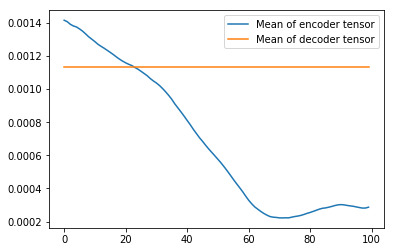

In [7]:
train_encoder.run(BATCH_SIZE, shuffle=True, n_iters = 100, bar=True, drop_last=True)

On the plot, we can see how encoder tensor mean and decoder tensor mean have been changing during the whole time of work of `train_encoder` pipeline. We see that only encoder tensor mean changes because in  `'encoder'` train step defined that the network can change weights only from encoder part.

Now we have the neural network with trained weights from scope of `'encoder'` train step.

Next, we train weights from the scope `'decoder'` train step.

In [8]:
train_decoder = (Pipeline(config=config)
                  .init_variable('encoder_tensor', [])
                  .init_variable('decoder_tensor', [])
                  .import_model('conv_nn', train_encoder)
                  .to_array()
                  .train_model('conv_nn', fetches=tensors_to_fetch,
                               train_mode='decoder',
                               images=B.images, masks=B.images,
                               save_to=[V('encoder_tensor', mode='a'), V('decoder_tensor', mode='a')],
                               use_lock=True)) << dataset.train

train_decoder.after.plot_tensor_mean(V('encoder_tensor'), V('decoder_tensor'))

100%|██████████| 100/100 [00:06<00:00, 16.80it/s]


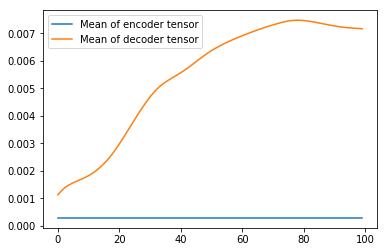

In [9]:
train_decoder.run(BATCH_SIZE, shuffle=True, n_iters=100, bar=True, drop_last=True)

On the second plot, we can see that the decoder tensor mean changes, and the encoder tensor mean does not change (`'decoder'` train step). It means that the `train_decoder` pipeline trains only the decoder part of the network.

Now we can get models with different training procedures, and thus we can get better results.